In [1]:

import numpy as np

import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
import tenpy

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from model_isingselfdual import TFISDModel

from scipy.optimize import curve_fit

tenpy.tools.misc.setup_logging(to_stdout="INFO")


In [2]:
# Parameters 

L = 100
chiMax = 700


model_params = {
    'p': 0.5 , 'lambda': 1.,  # for lambda=1 and p "small enough" the model should be critical
    'L': L,
    'bc_MPS': 'finite',
}

M = TFISDModel(model_params)

INFO    : TFISDModel: reading 'bc_MPS'='finite'
INFO    : TFISDModel: reading 'L'=100
INFO    : TFISDModel: reading 'p'=0.5
INFO    : TFISDModel: reading 'lambda'=1.0


In [3]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

#Run DMRG 

dmrg_params = {
    'mixer': None,  # setting this to True helps to escape local minima
    'max_E_err': 1.e-10,
    'trunc_params': {
        'chi_max': chiMax,
        'svd_min': 1.e-10,
    },
    'combine': True
}

engine = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)

E, psi = engine.run() # the main work; modifies psi in place

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'combine'=True
INFO    : TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO    : TwoSiteDMRGEngine: reading 'mixer'=None
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=700
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : checkpoint after sweep 1
energy=-180.7381150134740437, max S=0.3847513074248280, age=100, norm_err=1.4e-01
Current memory usage 123680.0MB, wall time: 3.4s
Delta E = nan, Delta S = 3.7746e-01 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 2.2737e-13
chi: 4
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-180.8281175880166245, max S=0.5471227996896897, age=100, norm_err=8.8e-03
Current memory usage 126636.0MB, wall time: 5.3s
Delta E = -9.0003e-02, Delta S = 1.3173e-01 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 3.6948e-13
chi: 16
INFO    : Running 

In [4]:
# E is the ground state energy directly returned by dmrg.run()

# there are other ways to extract the energy from psi:
E1 = M.H_MPO.expectation_value(psi)  # based on the MPO

print("ground state energy = ", E, E1)

#E2 = np.sum(M.bond_energies(psi))  # based on bond terms of H, works only for a NearestNeighborModel
assert abs(E-E1) < 1.e-10


ground state energy =  -180.82860780437127 -180.828607804371


In [5]:
#Bond dimensions
print(psi.chi)

[2, 4, 8, 16, 32, 61, 69, 74, 80, 83, 88, 91, 95, 98, 103, 106, 108, 111, 114, 117, 120, 121, 123, 126, 129, 131, 133, 136, 137, 138, 140, 142, 143, 143, 143, 144, 146, 147, 147, 147, 147, 149, 150, 150, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 150, 150, 149, 147, 147, 147, 147, 145, 144, 143, 143, 143, 142, 140, 138, 137, 136, 133, 131, 129, 126, 123, 121, 120, 117, 114, 111, 108, 106, 103, 98, 95, 91, 88, 83, 80, 74, 69, 61, 32, 16, 8, 4, 2]


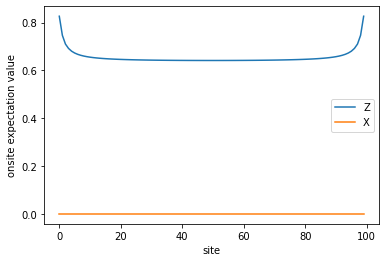

In [6]:


# onsite expectation values

X = psi.expectation_value("Sigmax")
Z = psi.expectation_value("Sigmaz")
x = np.arange(psi.L)
plt.figure()
plt.plot(x, Z, label="Z")
plt.plot(x, X, label="X")   # note: it's clear that this is zero due to charge conservation!
plt.xlabel("site")
plt.ylabel("onsite expectation value")
plt.legend()
plt.show()

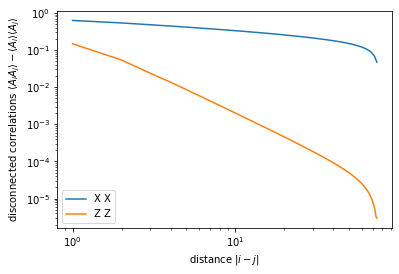

In [7]:
# correlation functions

i0 = psi.L // 4  # for fixed `i`
j = np.arange(i0 + 1, psi.L)
XX = psi.term_correlation_function_right([("Sigmax", 0)], [("Sigmax", 0)], i_L=i0, j_R=j)
XX_disc = XX - X[i0] * X[j]
ZZ = psi.term_correlation_function_right([("Sigmaz", 0)], [("Sigmaz", 0)], i_L=i0, j_R=j)
ZZ_disc = ZZ - Z[i0] * Z[j]

dx = j - i0
plt.figure()
plt.plot(dx, XX_disc, label="X X")
plt.plot(dx, ZZ_disc, label="Z Z")
plt.xlabel(r"distance $|i-j|$")
plt.ylabel(r"disconnected correlations $\langle A_i A_j\rangle - \langle A_i \rangle\langle A_j\rangle$")
plt.legend()
plt.loglog()
plt.show()

[0.29491 0.34421 0.38127 0.40693 0.4269  0.44303 0.45653 0.4681  0.47819 0.48713 0.49513 0.50235
 0.50892 0.51493 0.52046 0.52557 0.5303  0.53469 0.53879 0.54261 0.54618 0.54953 0.55266 0.5556
 0.55836 0.56095 0.56338 0.56566 0.56779 0.56979 0.57167 0.57342 0.57505 0.57656 0.57797 0.57927
 0.58047 0.58157 0.58258 0.58349 0.5843  0.58503 0.58567 0.58622 0.58668 0.58706 0.58735 0.58756
 0.58768 0.58773 0.58768 0.58756 0.58735 0.58706 0.58668 0.58622 0.58567 0.58503 0.5843  0.58349
 0.58258 0.58157 0.58047 0.57927 0.57797 0.57656 0.57505 0.57342 0.57167 0.56979 0.56779 0.56566
 0.56338 0.56095 0.55836 0.5556  0.55266 0.54953 0.54618 0.54261 0.53879 0.53469 0.5303  0.52557
 0.52046 0.51493 0.50892 0.50235 0.49513 0.48713 0.47819 0.4681  0.45653 0.44303 0.4269  0.40693
 0.38127 0.34421 0.29491]


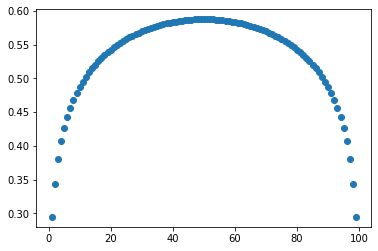

In [8]:
bonds = range(1,L)
entrop = psi.entanglement_entropy()
plt.figure()
plt.scatter(bonds,entrop)

print(entrop)

[0.45842 1.94043]
 
0.0764 x + 0.3234
0.5079925991235952


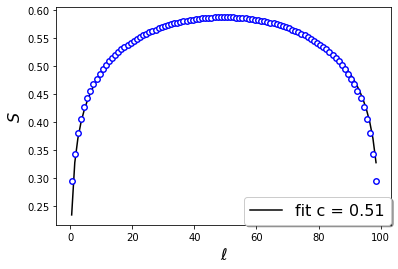

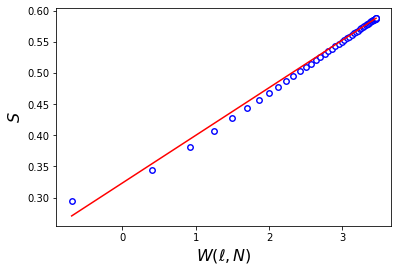

In [9]:


# Fit the central charge "c" against the CFT prediction

def fitFunc(x, c, a):
        return (c / 6) * np.log(L/np.pi * np.sin(np.pi*x/L)) + a

ell= np.arange(0.5, L-1)
entropies= np.array(entrop)

w_l_L = [np.log(L/np.pi*np.sin(np.pi*ell[k]/L)) for k in range(0,len(ell))]

fitParams, fitCovariances = curve_fit(fitFunc,ell[10:-10] ,entropies[10:-10])

plt.errorbar(ell,
                 entropies,
                 fmt='o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)

plt.plot(ell,
             fitFunc(ell, fitParams[0], fitParams[1]),
             linewidth=1.5,
             c='black',
             label='fit c = {c:.2f}'.format(c = fitParams[0]))

plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$S$', fontsize=16)

plt.legend(loc='lower right', borderaxespad=0., fancybox=True, shadow=True, fontsize=16)

fig_ent= plt.figure()

plt.plot(w_l_L[0:50],entropies[0:50], 'o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4 )

plt.xlabel(r'$W(\ell,N)$', fontsize=16)
plt.ylabel(r'$S$', fontsize=16)

z2= np.polyfit(w_l_L[40:50], entropies[40:50], 1)
p2=np.poly1d(z2)

plt.plot(np.linspace(np.min(w_l_L),np.max(w_l_L)),p2(np.linspace(np.min(w_l_L),np.max(w_l_L))),'-',color='red')

print(z2*6)
print(p2)

central_charge, const, res = tenpy.tools.fit.central_charge_from_S_profile(psi)
print(central_charge)

Text(0, 0.5, '$\\Delta_i/\\Delta_j$')

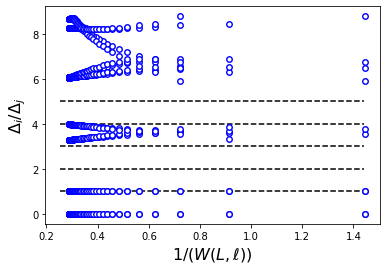

In [10]:
spectrum = psi.entanglement_spectrum()

#ent_gaps=[spectrum[k]-spectrum[k][0] for k in  range(len(spectrum))]
ent_gaps = [lam - lam[0] for lam in spectrum]

#ent_ratios=[ent_gaps[k][0:10]/ent_gaps[k][1] for k in  range(len(spectrum))]
ent_ratios = [rr[0:8]/rr[1] for rr in ent_gaps]

for pos in range(2,L-1):
    elle=1./(np.log(L/np.pi*np.sin(np.pi*float(pos)/L)))*np.ones(len(ent_ratios[pos]))
    plt.errorbar(elle,
                 ent_ratios[pos],
                 fmt='o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)

plt.hlines([1,2,3,4,5],
     1./np.log(L/2+1), 1./np.log(2), colors='k', linestyles='dashed')

#plt.hlines([3.5],   1./np.log(L/2+1),  1./np.log(2), colors='r', linestyles='dashed')

plt.xlabel(r'$1/(W(L,\ell))$', fontsize=16)
plt.ylabel(r'$\Delta_i/\Delta_j$', fontsize=16)

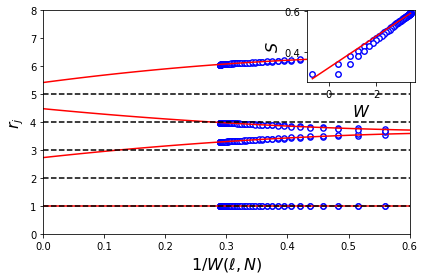

In [11]:
low=3
high=L-low

fig = plt.figure()
for num_ratio in range(1,5):
    first_ratio=[ent_ratios[k][num_ratio] for k in  range(low,high) ]
#p=range(1,len(spectrum))
#inverse_log=[1./np.log((np.float(k))) for k in range(2,L-1)]
    inverse_log=[1./(np.log(L/np.pi*np.sin(np.pi*float(k)/L))) for k in range(low,high)]
    #def quadfit(x, a, b,c):
    #        return a*x*x+b*x+c
    
    z = np.polyfit(inverse_log, first_ratio, 2)
    p = np.poly1d(z)
    #fitParams, fitCovariances = curve_fit(quadfit,inverse_log ,first_ratio)
    

    plt.plot(inverse_log, first_ratio,'.',
                 c='blue',
                 ms=10.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)

#plt.plot(np.linspace(0.2,1.4,100),
 #            quadfit(np.linspace(0,0.3,100), fitParams[0], fitParams[1], fitParams[2]),
  #           linewidth=1.5,
   #          c='black',
    #         label='fit c = {c:.2f}'.format(c = fitParams[2]))
    plt.plot(np.linspace(0.,1.5,100), p(np.linspace(0.,1.5,100)),'-',
                 c='red',
                 markeredgewidth=1.4)
   # label='fit c = {c:.2f}'.format(c = fitParams[2]))
   # fitParams[2]
   # plt.legend(loc='lower right', borderaxespad=0., fancybox=True, shadow=True, fontsize=16)

plt.hlines([1,2,3,4,5],  0, 1./np.log(2), colors='k', linestyles='dashed')
#plt.hlines([3.5],
  #    0,  1./np.log(2), colors='r', linestyles='dashed')
plt.xlabel(r'$1/W(\ell,N)$', fontsize=16)
plt.xlim([0,0.6])
plt.ylim([0,8])
plt.ylabel(r'$r_j$', fontsize=16)
#ax2 = plt.axes([0,0,1,1])
plt.tight_layout()
ax2=fig.add_axes([0.72, 0.7, 0.25, 0.25]) 

ax2.plot(w_l_L,entropies, 'o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4 )

ax2.set_xlabel(r'$W$', fontsize=16)
ax2.set_ylabel(r'$S$', fontsize=16)

ax2.plot(np.linspace(np.min(w_l_L),np.max(w_l_L)),p2(np.linspace(np.min(w_l_L),np.max(w_l_L))),'-',color='red')